# Exercício - Projeto completo

In [1]:
import numpy as np
import control as ct

In [2]:
a = np.random.randint(low=1,high=9,size=3)
b = np.random.randint(low=1,high=9,size=2)
print(a)
print(b)

[7 7 3]
[1 6]


<span style="color:blue"> **Sistema** </span>
$$
\begin{align}
    G(s) &= \frac{b_1s+b_0}{s^3+a_2s^2+a_1s+a_0}
\end{align}
$$

In [3]:
den = np.block([1,a])
G = ct.tf(b,den)
print(G)


        s + 6
---------------------
s^3 + 7 s^2 + 7 s + 3



In [4]:
ct.damp(G)

_____Eigenvalue______ Damping___ Frequency_
      -5.9                     1        5.9
   -0.5502   +0.4537j     0.7715     0.7131
   -0.5502   -0.4537j     0.7715     0.7131


(array([5.89968779, 0.7130929 , 0.7130929 ]),
 array([1.        , 0.77150692, 0.77150692]),
 array([-5.89968779+0.j        , -0.55015611+0.45368463j,
        -0.55015611-0.45368463j]))

In [5]:
ct.zeros(G)

array([-6.+0.j])

Especificações:
- Integrador (malha aberta)
- Amortecimento: 0.6
- Frequência natural: 4

In [6]:
xi = 0.6
wn = 4
p = -xi*wn+1j*wn*np.sqrt(1-xi**2)
print(p)

(-2.4+3.2j)


O sistema é de 3a ordem. Com o integrador ficará de 4a (antes do observador). Então, além dos dominantes, precisamos alocar mais dois polos. Vamos colocar um em cima do zero, para cancelar, e outro arbitrário real, 4x maior que a parte real do dominante.

In [7]:
polos_desejados = [p,np.conjugate(p),ct.zeros(G)[0],4*np.real(p)]
print(polos_desejados)
poli_mf = np.poly(polos_desejados) # contrario da função roots()
print(poli_mf)

[(-2.4+3.2j), (-2.4-3.2j), (-6+0j), -9.6]
[  1.    20.4  148.48 526.08 921.6 ]


Então o polinômio desejado é:
$$
\begin{align}
    \alpha(s) &=s^4+17.8s^3+90.4s^2+265.6s+192
\end{align}
$$

Vamos agora definir o sistema no espaço de estados usando FCC

In [9]:
# Apenas o sistema! (sem integrador ainda)
F = np.block([[-a],[np.eye(2), np.zeros((2,1))]])
G = np.block([[1],[np.zeros((2,1))]])
H = np.block([[0,b]])
J = 0
n = F.shape[0]

Agora, aumentar as matrizes para o projeto com integrador:

In [10]:
Fa = np.block([ [   F,   np.zeros((n,1)) ],
                [  -H,   0          ]])

Ga = np.block([[G], [0]])

print(Fa)
print("")
print(Ga)

[[-7. -7. -3.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0. -1. -6.  0.]]

[[1.]
 [0.]
 [0.]
 [0.]]


Alocação de polos com integrador

In [11]:
Ka = ct.acker(Fa,Ga,polos_desejados)
K = Ka[:,0:n]
Ki = Ka[:,-1]
print(Ka)
print("")
print(K)
print("")
print(Ki)

[[  13.4   141.48  369.48 -153.6 ]]

[[ 13.4  141.48 369.48]]

[-153.6]


Notar que:
$$
\begin{align}
    \mathbf{K} &= \left[\begin{array}{ccc}15.8 & 89.4 & 68.6\end{array}\right]\\   
     K_i &= -24
\end{align}
$$

Polos do observador serão reais e iguais, a um fator de 4 da parte real dos pólos dominantes:

In [14]:
po = 4*np.real(p)
#print(po)
L = ct.acker(F.T, H.T, [po]*n).T      # [po]*n = repete a lista n vezes, ou seja [po,po,po]
print("Ganhos do observador. L = ")
print(L)

Ganhos do observador. L = 
[[581.952]
 [-77.512]
 [ 16.552]]


4. Equações do controlador

In [16]:
Fc = np.block([[F-G@K-L@H, np.zeros((n,1))],[np.zeros((1,n+1))]])
Gc = np.block([[L, np.zeros((n,1))],[np.array([-1,1])]])
Hc = -Ka
cont = ct.ss(Fc,Gc,Hc,0)
print(cont)

<LinearIOSystem>: sys[4]
Inputs (2): ['u[0]', 'u[1]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-2.040000e+01 -7.304320e+02 -3.864192e+03  0.000000e+00]
     [ 1.000000e+00  7.751200e+01  4.650720e+02  0.000000e+00]
     [ 0.000000e+00 -1.555200e+01 -9.931200e+01  0.000000e+00]
     [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]]

B = [[581.952   0.   ]
     [-77.512   0.   ]
     [ 16.552   0.   ]
     [ -1.      1.   ]]

C = [[ -13.4  -141.48 -369.48  153.6 ]]

D = [[0. 0.]]



Funções de transferência

In [21]:
(ct.tf(cont))

TransferFunction([[array([  -3100.992     ,  -32827.2368    , -162514.05887992,
       -454238.20799967]), array([1.53600000e+02, 6.48192000e+03, 1.09068288e+05, 4.54238208e+05])]], [[array([1.00000000e+00, 4.22000000e+01, 7.10080000e+02, 2.95728000e+03,
       3.45607987e-11]), array([1.00000000e+00, 4.22000000e+01, 7.10080000e+02, 2.95728000e+03,
       3.45607987e-11])]])

5. Simulação

In [43]:
Fmf = np.block([[F,-G@K,-G*Ki],[L@H,F-G@K-L@H,-G*Ki],[-H,np.zeros((1,n+1))]])
Gmf = np.block([[np.zeros((2*n,1))],[1]])
Hmf_y = np.block([[H,np.zeros((1,n+1))]])
Hmf_u = np.block([[-Ka,np.zeros((1,n))]])
Jmf = 0
MF_y = ct.ss(Fmf,Gmf,Hmf_y,Jmf)
MF_u = ct.ss(Fmf,Gmf,Hmf_u,Jmf)
#print(MF)
T=(ct.damp(MF_y))
print("")
print(ct.zeros(MF_y))

_____Eigenvalue______ Damping___ Frequency_
      -2.4      +3.2j        0.6          4
      -2.4      -3.2j        0.6          4
    -9.602                     1      9.602
      -9.6 +0.001752j          1        9.6
      -9.6 -0.001752j          1        9.6
    -9.598                     1      9.598
        -6                     1          6

[-9.60039863+0.j         -9.59980068+0.00034522j -9.59980068-0.00034522j
 -6.        +0.j        ]


In [44]:
ts = 4/abs(np.real(p))
t,y = ct.step_response(MF_y,3*ts)
t,u = ct.step_response(MF_u,3*ts)


1.6666666666666667


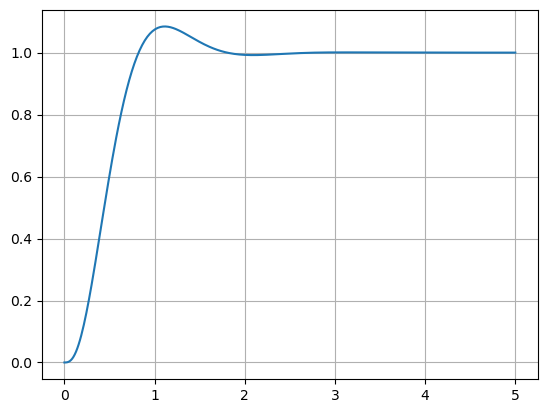

In [45]:
from matplotlib import pyplot as plt

plt.plot(t,y)
plt.grid()
np.max(y)
print(ts)

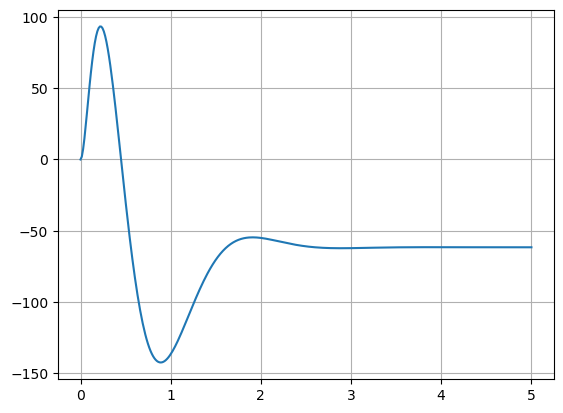

In [46]:
plt.plot(t,u)
plt.grid()